# Using Scalers to Improve Classifier Efficacy
Eric Hanley

*Explanation about why scaling is important in machine learning*

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix, recall_score, f1_score

### Read CSV and Review Data

In [2]:
X_full = pd.read_csv('heart.csv.xls')
y = X_full.output
X = X_full.drop(['output'], axis=1)
X_full.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


From this quick peak, we can see that age, trtbps, chol, thalachh, and potentially oldpeak could all be standardized to work better with our classifier.

### Now we'll define a function getMetrics that accepts a scaler (or scaler = None). If no scaler is passed to getMetrics, it simply creates what we call the "base model". If a scaler is passed, then the features age, trtbps, thalachh, oldpeak, and chol are scaled using the scaler specified. The function returns the feature importance of the model and the metrics of the model.

In [3]:
def getMetrics(scaler):
    
    #If we have passed a scaler to the function, then we'll want to apply it to the features mentioned above.
    if scaler != None:
        #Fit and transform the relevant features using the scaler -- returns a numpy array.
        scaled_columns = scaler.fit_transform(X[['age', 'trtbps','thalachh','oldpeak','chol']])

        #Turn numpy array into a dataframe.
        scaledData = pd.DataFrame(scaled_columns, columns = ['age_s', 'trtbps_s','thalachh_s','oldpeak_s','chol_s'])

        #Create another dataframe without the columns to be transformed.
        X_merge = X.drop(columns = ['age','trtbps','thalachh','oldpeak','chol'])

        #Join the two dataframes together.
        X_scaled = X_merge.join(scaledData)
    #If no scaler is passed, then we create the base model.
    else:
        X_scaled = X
    
    #Split data into training and validation sets.
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2, random_state=0)

    #Create RandomForestClassifier Model object.
    base_model = RandomForestClassifier(random_state=42)

    #Fit the features (X) and the target (y) to the model object using the training data sets.
    base_model.fit(Xtrain,ytrain)

    #Create predictions based off the validation data set.
    base_preds = base_model.predict(Xvalid)

    #Generate metrics to determine the efficacy of the model - accuracy, average precision, recall, and F1.
    baseAcc = accuracy_score(base_preds,yvalid)
    baseAvgPrec = average_precision_score(base_preds,yvalid)
    recall = recall_score(base_preds,yvalid)
    F = f1_score(base_preds,yvalid)

    #Print out the metrics.
    print('Accuracy: ' + str(round(baseAcc*100,2))+'%')
    print('Avg. Precision Score: ' + str(round(baseAvgPrec*100,2))+'%')
    print('Recall: ' + str(round(recall*100,2))+'%')
    print('F1: ' + str(round(F*100,2))+'%')
    
    #Save metrics as a dictionary
    metrics = {'labels':['Accuracy','Avg. Precision Score', 'Recall', 'F1'], 'values':[baseAcc,baseAvgPrec,recall,F]}
    
    #Create the DataFrame feat_imp which contains a qunatitative value of the importance of each feature when classifying.
    feat_imp = pd.DataFrame(base_model.feature_importances_, index = Xtrain.columns, columns=['Feature Importance'])

    fig, ax = plt.subplots()
    feat_imp.plot.bar(yerr=feat_imp, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    print()
    print('Feature Importance:')
    print(feat_imp['Feature Importance'])
    
    return feat_imp, metrics

### Base Model

Without changing any of the features we've identified, the base model determines feature importance/utilizes the data as is. That means it will assign more importance to features that are numerically large, when that may not be called for. Pay special attention to the features that are not scaled - age, trtbps, thalachh, oldpeak, and chol.

Accuracy: 85.25%
Avg. Precision Score: 83.83%
Recall: 85.71%
F1: 86.96%

Feature Importance:
age         0.082161
sex         0.043652
cp          0.123409
trtbps      0.073234
chol        0.078784
fbs         0.011673
restecg     0.017193
thalachh    0.126226
exng        0.062990
oldpeak     0.122961
slp         0.038411
caa         0.123474
thall       0.095832
Name: Feature Importance, dtype: float64


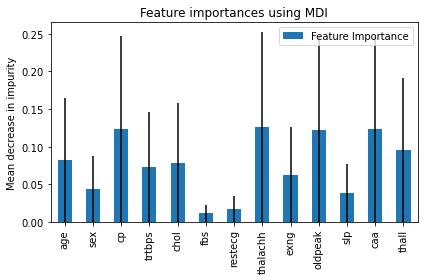

In [4]:
base_feat_imp, base_metrics = getMetrics(scaler = None)

### MinMaxScaler

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data. MinMaxScaler doesn’t reduce the importance of outliers.

Accuracy: 86.89%
Avg. Precision Score: 84.41%
Recall: 88.24%
F1: 88.24%

Feature Importance:
sex           0.047670
cp            0.109369
fbs           0.009506
restecg       0.022452
exng          0.049608
slp           0.043861
caa           0.147242
thall         0.107041
age_s         0.086315
trtbps_s      0.071412
thalachh_s    0.133135
oldpeak_s     0.093109
chol_s        0.079279
Name: Feature Importance, dtype: float64


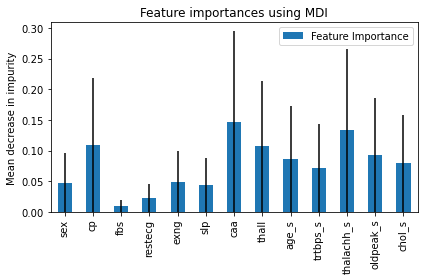

In [5]:
minMax_feat_imp, minMax_metrics = getMetrics(scaler = MinMaxScaler())

### RobustScaler

RobustScaler transforms the feature vector by subtracting the median and then dividing by the interquartile range (75% value — 25% value). Like MinMaxScaler, our feature with large values — normal-big — is now of similar scale to the other features. Note that RobustScaler does not scale the data into a predetermined interval like MinMaxScaler. It does not meet the strict definition of scale I introduced earlier.


Accuracy: 86.89%
Avg. Precision Score: 84.41%
Recall: 88.24%
F1: 88.24%

Feature Importance:
sex           0.047670
cp            0.109369
fbs           0.009506
restecg       0.022452
exng          0.049608
slp           0.043861
caa           0.147242
thall         0.107041
age_s         0.086315
trtbps_s      0.071412
thalachh_s    0.133135
oldpeak_s     0.093109
chol_s        0.079279
Name: Feature Importance, dtype: float64


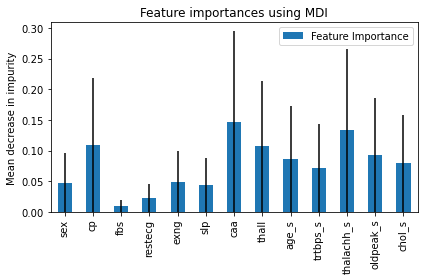

In [6]:
robust_feat_imp, robust_metrics = getMetrics(scaler = RobustScaler())

### StandardScaler

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler does not meet the strict definition of scale I introduced earlier.
StandardScaler results in a distribution with a standard deviation equal to 1. The variance is equal to 1 also, because variance = standard deviation squared. And 1 squared = 1. StandardScaler makes the mean of the distribution 0. About 68% of the values will lie be between -1 and 1.

Accuracy: 86.89%
Avg. Precision Score: 84.41%
Recall: 88.24%
F1: 88.24%

Feature Importance:
sex           0.047670
cp            0.109369
fbs           0.009506
restecg       0.022452
exng          0.049608
slp           0.043861
caa           0.147242
thall         0.107041
age_s         0.086315
trtbps_s      0.071412
thalachh_s    0.133135
oldpeak_s     0.093109
chol_s        0.079279
Name: Feature Importance, dtype: float64


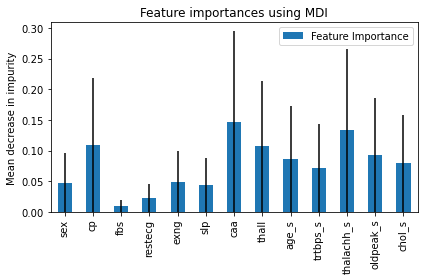

In [7]:
standard_feat_imp, standard_metrics = getMetrics(scaler = StandardScaler())

As you can see, scaling our features significantly changes how the model attaches importance to different features. Base feature importance is very different from standardardized feature importance and normalized feature importance. Standard and MinMax are identical (as would be Robust).

# Metric Comparison

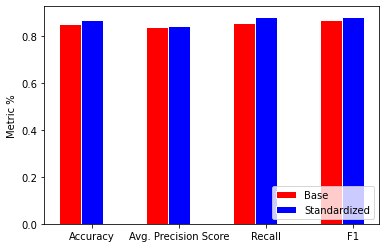

In [8]:
# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = base_metrics['values']
bars2 = standard_metrics['values']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='Base')
plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='Standardized')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], labels = base_metrics['labels'])
plt.ylabel('Metric %')
 
# Create legend & Show graphic
plt.legend(loc = 'lower right')
plt.show()

Again, we can see that the standardized features result in a more accurate and precise model with better recall compared to the base model.

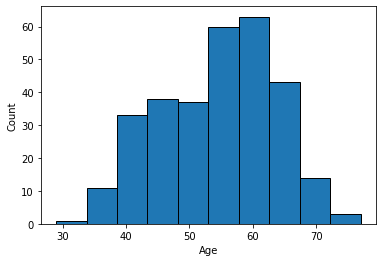

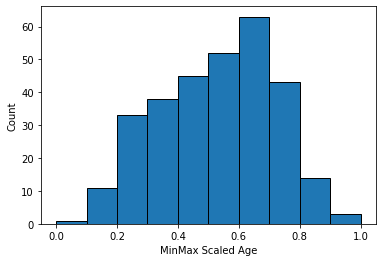

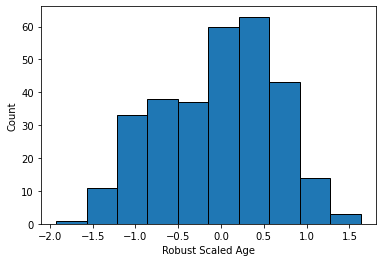

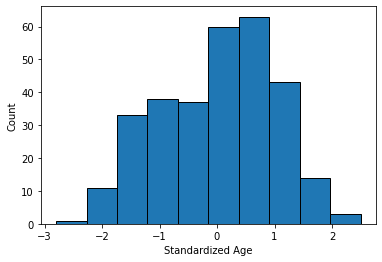

In [12]:
plt.hist(X['age'], edgecolor = 'black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

minMax_age = MinMaxScaler().fit_transform(X[['age']])
minMax_age = pd.DataFrame(minMax_age, columns = ['s_age'])

plt.hist(minMax_age['s_age'], edgecolor = 'black')
plt.xlabel('MinMax Scaled Age')
plt.ylabel('Count')
plt.show()

robust_age = RobustScaler().fit_transform(X[['age']])
robust_age = pd.DataFrame(robust_age, columns = ['s_age'])

plt.hist(robust_age['s_age'], edgecolor = 'black')
plt.xlabel('Robust Scaled Age')
plt.ylabel('Count')
plt.show()

standardized_age = StandardScaler().fit_transform(X[['age']])
standardized_age = pd.DataFrame(standardized_age, columns = ['s_age'])

plt.hist(standardized_age['s_age'], edgecolor = 'black')
plt.xlabel('Standardized Age')
plt.ylabel('Count')
plt.show()